# 🧠 LGG Brain Tumor Segmentation with UNet

## Model Overview
- **Architecture:** UNet
- **Encoder:** ResNet34 (pretrained on ImageNet for training)
- **Input channels:** 1 (grayscale MRI)
- **Output channels/classes:** 1 (binary tumor mask)
- **Loss functions:** Dice Loss + Binary Cross-Entropy Loss
- **Optimizer:** Adam (lr=1e-4)
- **Device:** GPU (if available)

## Dataset Overview
- **Source folders:** `kaggle_3m`, `lgg-mri-segmentation/kaggle_3m`
- **Total .tif files:** 15716
- **Patients (folders):** 220
- **Original slices:**
  - Tumor: 2746
  - Non-tumor: 5112

### Balancing Tumor Slices
- Augmented tumor slices using:
  - Horizontal & vertical flips
  - Rotation, brightness/contrast, shift/scale
- **Augmented dataset:**
  - Tumor slices: 2746
  - Non-tumor slices: 0
  - Total slices: 2746
- **Augmentation saved to:** `augmented_dataset/images` & `augmented_dataset/masks`

## Data Splits
- **Training:** 80%
- **Validation:** 10%
- **Test:** 10%
- **Batch size:** 32
- **Transforms:** 
  - Train: Resize + flips + shift/scale/rotate
  - Validation/Test: Resize only

## Training
- **Epochs:** 40
- **Live plotting of training & validation loss**
- **Final train loss:** 0.1081 
- **Final val loss:** 0.1098
- **Final test loss:** 0.1055

## Visualization
- Random examples of:
  - MRI slices
  - Ground truth masks
  - Model predictions
- Also visualized augmented tumor slices


In [23]:
import os
import glob
from pathlib import Path
import random
import numpy as np
import pandas as pd
import cv2
cv2.setNumThreads(0)

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)

# === USING LOCAL DATA FOLDERS ===
candidates = [
    Path("data/kaggle_3m"),
    Path("data/lgg-mri-segmentation") / "kaggle_3m",
]
existing = [p for p in candidates if p.exists()]
if not existing:
    print("No local data folders found. Checked:", [str(p) for p in candidates])
else:
    print("Using data folders:", [str(p) for p in existing])

# === Collect image–mask pairs from all existing data folders ===
all_tif = []
for root in existing:
    all_tif.extend(glob.glob(str(root / "**/*.tif"), recursive=True))
all_tif = sorted(all_tif)
mask_files = [f for f in all_tif if f.endswith("_mask.tif")]
image_files = [f for f in all_tif if not f.endswith("_mask.tif")]

print("Total .tif files:", len(all_tif))
print("Images:", len(image_files))
print("Masks:", len(mask_files))

pairs = []
for img_path in image_files:
    img_path = Path(img_path)
    mask_path = img_path.with_name(img_path.stem + "_mask.tif")
    if mask_path.exists():
        pairs.append((str(img_path), str(mask_path)))

print("Valid pairs:", len(pairs))

df = pd.DataFrame(pairs, columns=["image_path", "mask_path"])
df.head()


Using data folders: ['data\\kaggle_3m', 'data\\lgg-mri-segmentation\\kaggle_3m']
Total .tif files: 15716
Images: 7858
Masks: 7858
Valid pairs: 7858
Valid pairs: 7858


,image_path,mask_path
0,data\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4...,data\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4...
1,data\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4...,data\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4...
2,data\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4...,data\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4...
3,data\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4...,data\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4...
4,data\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4...,data\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4...


Number of patient folders: 220

Slices per patient (first 10):
image_path
TCGA_CS_4941_19960909    46
TCGA_CS_4942_19970222    40
TCGA_CS_4943_20000902    40
TCGA_CS_4944_20010208    40
TCGA_CS_5393_19990606    40
TCGA_CS_5395_19981004    40
TCGA_CS_5396_20010302    48
TCGA_CS_5397_20010315    44
TCGA_CS_6186_20000601    50
TCGA_CS_6188_20010812    48
Name: count, dtype: int64


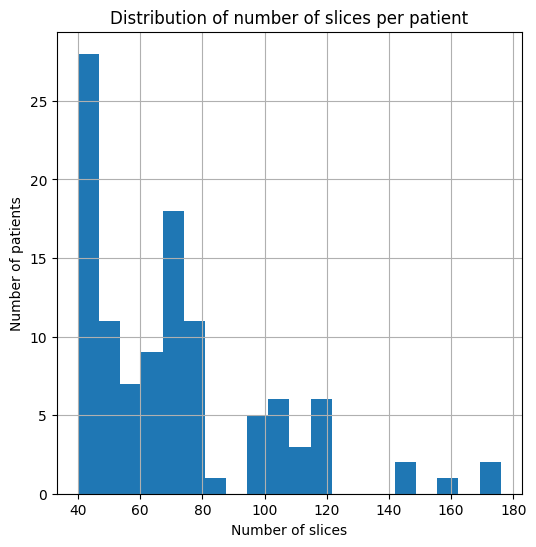

In [24]:
# Number of patients (folders) — computed from image file parent directories
patient_dirs = sorted({Path(p).parent for p in image_files})
print(f"Number of patient folders: {len(patient_dirs)}")

# Count slices per patient
slices_per_patient = (
    df["image_path"]
    .apply(lambda p: Path(p).parent.name)
    .value_counts()
    .sort_index()
)

print("\nSlices per patient (first 10):")
print(slices_per_patient.head(10))

plt.figure()
slices_per_patient.hist(bins=20)
plt.title("Distribution of number of slices per patient")
plt.xlabel("Number of slices")
plt.ylabel("Number of patients")
plt.show()


In [25]:
def get_shape(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)  # keep as stored
    return img.shape  # (H, W, C)

# Sample some files (or use all, but that’s slower)
sample_paths = df.sample(min(200, len(df)), random_state=42)

img_shapes = [get_shape(p) for p in sample_paths["image_path"]]
mask_shapes = [get_shape(p) for p in sample_paths["mask_path"]]

print("Unique image shapes in sample:", set(img_shapes))
print("Unique mask shapes in sample:", set(mask_shapes))

# If you want to check separately height/width
heights = [s[0] for s in img_shapes]
widths  = [s[1] for s in img_shapes]

print(f"Image height: mean={np.mean(heights):.1f}, min={np.min(heights)}, max={np.max(heights)}")
print(f"Image width : mean={np.mean(widths):.1f}, min={np.min(widths)}, max={np.max(widths)}")


Unique image shapes in sample: {(256, 256, 3)}
Unique mask shapes in sample: {(256, 256)}
Image height: mean=256.0, min=256, max=256
Image width : mean=256.0, min=256, max=256


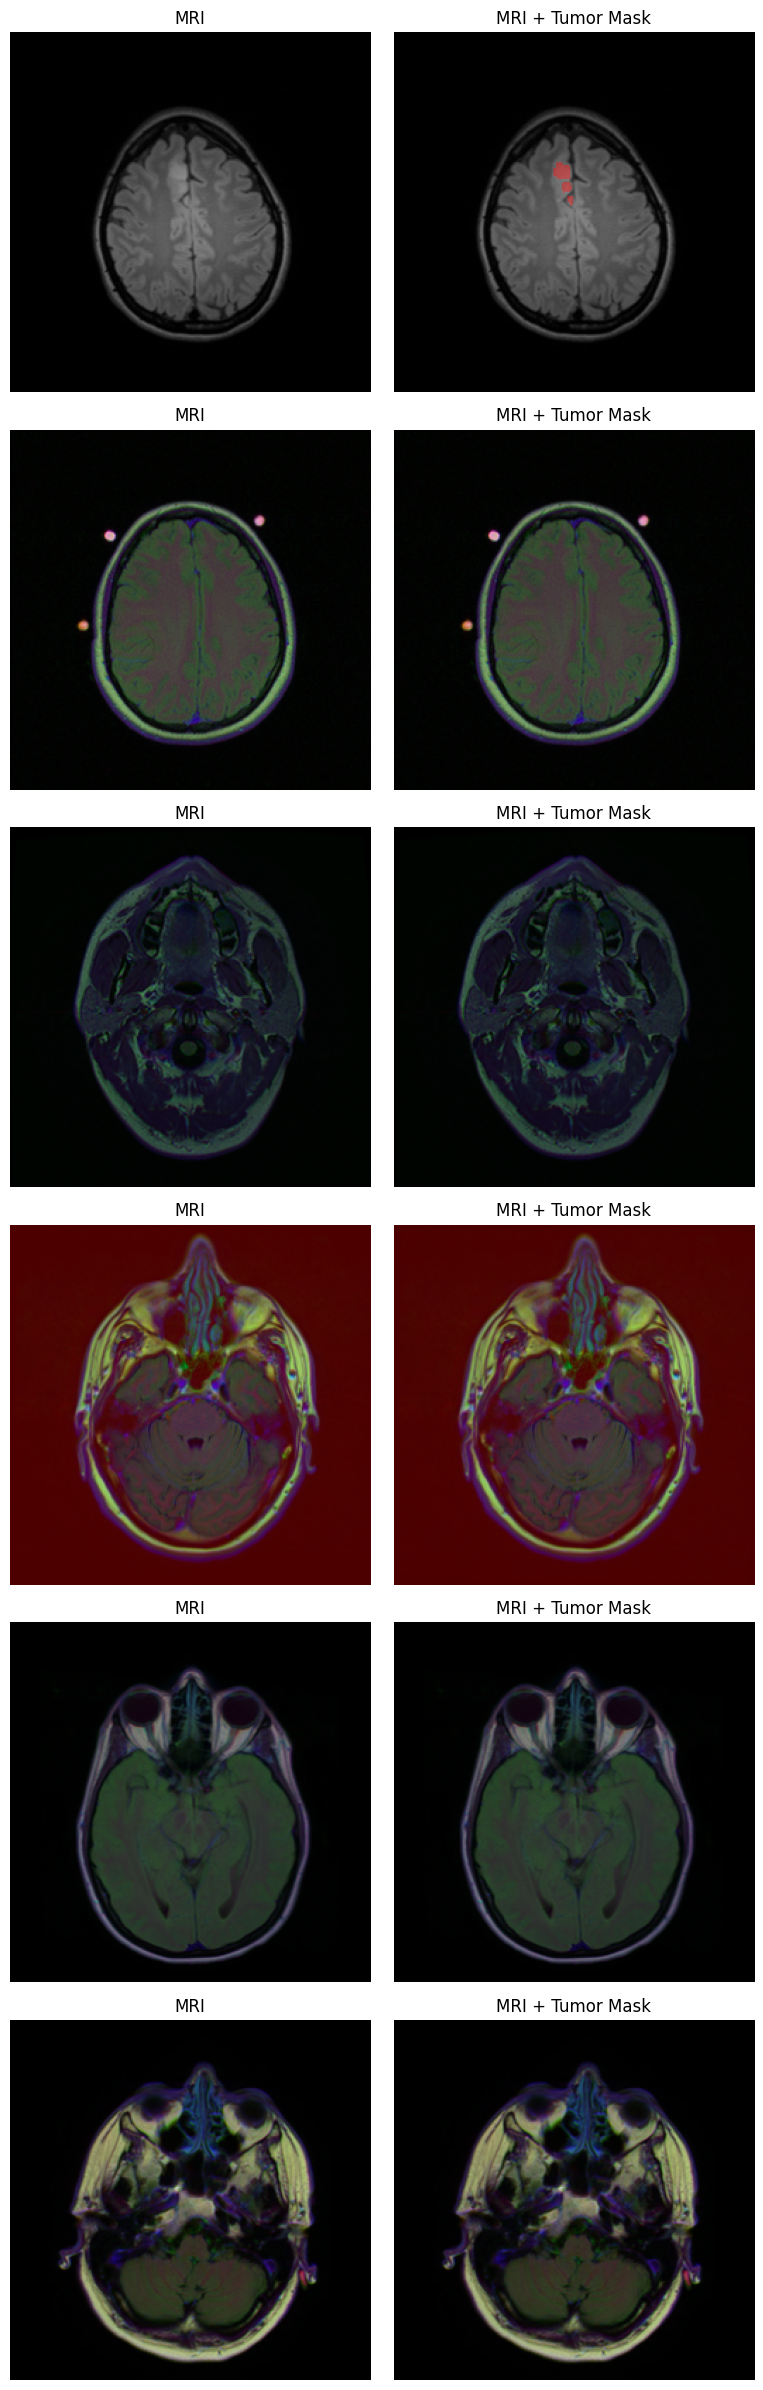

In [26]:
def show_random_examples(df, n=4):
    rows = n       # one row per example
    cols = 2       # MRI | MRI+Mask

    sample = df.sample(n, random_state=random.randint(0, 10_000))
    plt.figure(figsize=(cols * 4, rows * 4))

    for i, row in enumerate(sample.itertuples(), 1):
        img = cv2.imread(row.image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(row.mask_path, cv2.IMREAD_GRAYSCALE)
        mask_norm = (mask > 0).astype(np.float32)

        # MRI only
        plt.subplot(rows, cols, 2*i - 1)
        plt.imshow(img)
        plt.title("MRI")
        plt.axis("off")

        # MRI + overlay
        overlay = img.copy().astype(np.float32)
        overlay[mask_norm == 1] = [255, 0, 0]
        blended = (0.6 * img + 0.4 * overlay).astype(np.uint8)

        plt.subplot(rows, cols, 2*i)
        plt.imshow(blended)
        plt.title("MRI + Tumor Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


show_random_examples(df, n=6)


Slices with tumor    : 2746
Slices without tumor : 5112


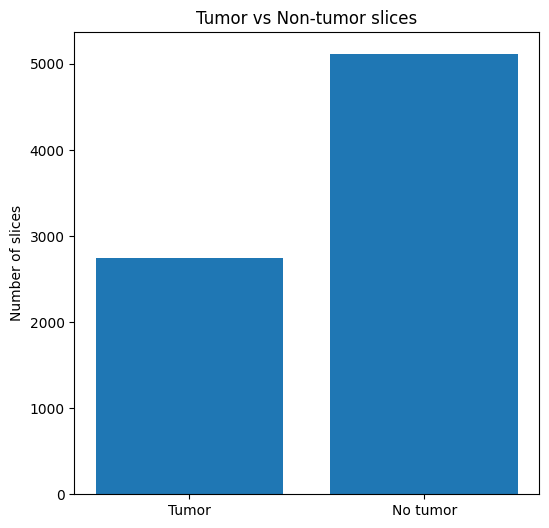

In [27]:
def has_tumor(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return int(mask.max() > 0)

df["tumor"] = df["mask_path"].apply(has_tumor)

tumor_counts = df["tumor"].value_counts().sort_index()
n_non_tumor = tumor_counts.get(0, 0)
n_tumor = tumor_counts.get(1, 0)

print(f"Slices with tumor    : {n_tumor}")
print(f"Slices without tumor : {n_non_tumor}")

plt.figure()
plt.bar(["Tumor", "No tumor"], [n_tumor, n_non_tumor])
plt.title("Tumor vs Non-tumor slices")
plt.ylabel("Number of slices")
plt.show()


Before balancing:
  Tumor slices    : 2746
  Non-tumor slices: 5112
Existing augmented images found: 2366
No new augmentations needed. Using existing augmented dataset.

After balancing:
  Tumor slices    : 5112
  Non-tumor slices: 5112
  Total slices    : 10224


c:\Users\jeanl\OneDrive\Documents\AUB\5thSemester\cmps261\.venv\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


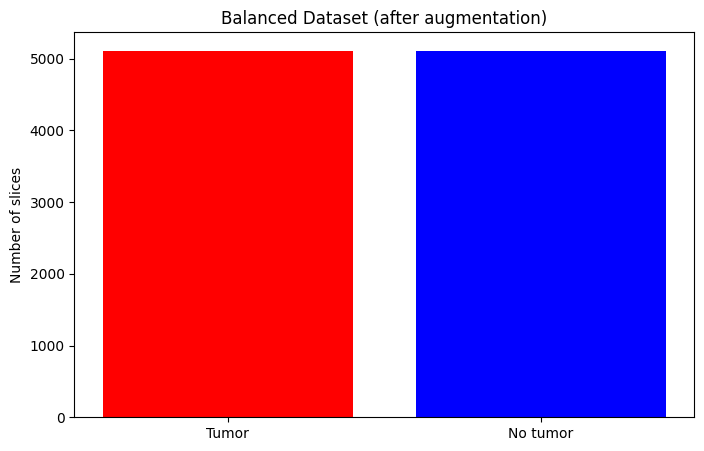

In [28]:
import albumentations as A
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

# --------------------------------------------------------
# 0) Prepare directories
# --------------------------------------------------------
aug_dir = Path("augmented_dataset")
aug_img_dir = aug_dir / "images"
aug_mask_dir = aug_dir / "masks"

aug_img_dir.mkdir(parents=True, exist_ok=True)
aug_mask_dir.mkdir(parents=True, exist_ok=True)

# --------------------------------------------------------
# 1) Separate tumor & non-tumor slices
# --------------------------------------------------------
tumor_df = df[df['tumor'] == 1].copy()
non_tumor_df = df[df['tumor'] == 0].copy()

print("Before balancing:")
print(f"  Tumor slices    : {len(tumor_df)}")
print(f"  Non-tumor slices: {len(non_tumor_df)}")

# --------------------------------------------------------
# 2) Augmentation pipeline
# --------------------------------------------------------
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.3)
])

# --------------------------------------------------------
# 3) Check existing augmented images
# --------------------------------------------------------
existing_aug_imgs = sorted(aug_img_dir.glob("aug_image_*.png"))
existing_aug_masks = sorted(aug_mask_dir.glob("aug_mask_*.png"))
existing_count = min(len(existing_aug_imgs), len(existing_aug_masks))
print(f"Existing augmented images found: {existing_count}")

# --------------------------------------------------------
# 4) How many more augmentations do we need?
# --------------------------------------------------------
n_needed = len(non_tumor_df) - len(tumor_df) - existing_count

augmented_rows = []

# --------------------------------------------------------
# 5) Generate only missing augmentations
# --------------------------------------------------------
if n_needed <= 0:
    print("No new augmentations needed. Using existing augmented dataset.")
else:
    print(f"Need to generate {n_needed} more augmented tumor images.")

    start_idx = existing_count  # continue numbering from existing files

    for idx in tqdm(range(start_idx, start_idx + n_needed)):
        row = tumor_df.sample(1).iloc[0]

        img_path = row["image_path"]
        mask_path = row["mask_path"]

        # Load original image + mask
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Apply augmentation
        augmented = augmentations(image=img, mask=mask)
        new_img = augmented["image"]
        new_mask = augmented["mask"]

        # Save augmented files
        new_img_path = aug_img_dir / f"aug_image_{idx}.png"
        new_mask_path = aug_mask_dir / f"aug_mask_{idx}.png"

        cv2.imwrite(str(new_img_path), cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR))
        cv2.imwrite(str(new_mask_path), new_mask)

        augmented_rows.append({
            "image_path": str(new_img_path),
            "mask_path": str(new_mask_path),
            "tumor": 1
        })

# --------------------------------------------------------
# 6) Build final balanced DataFrame
# --------------------------------------------------------
# Include existing augmented images automatically
existing_augmented_rows = [{
    "image_path": str(img),
    "mask_path": str(aug_mask_dir / img.name.replace("aug_image_", "aug_mask_")),
    "tumor": 1
} for img in existing_aug_imgs]

all_augmented_rows = existing_augmented_rows + augmented_rows
augmented_df = pd.DataFrame(all_augmented_rows)

df_balanced = pd.concat([non_tumor_df, tumor_df, augmented_df], ignore_index=True)

print("\nAfter balancing:")
print(f"  Tumor slices    : {(df_balanced['tumor'] == 1).sum()}")
print(f"  Non-tumor slices: {(df_balanced['tumor'] == 0).sum()}")
print(f"  Total slices    : {len(df_balanced)}")

# --------------------------------------------------------
# 7) Visualize balance
# --------------------------------------------------------
plt.figure(figsize=(8, 5))
balanced_counts = df_balanced['tumor'].value_counts().sort_index()
plt.bar(["Tumor", "No tumor"],
        [balanced_counts.get(1, 0), balanced_counts.get(0, 0)],
        color=['red', 'blue'])
plt.title("Balanced Dataset (after augmentation)")
plt.ylabel("Number of slices")
plt.show()


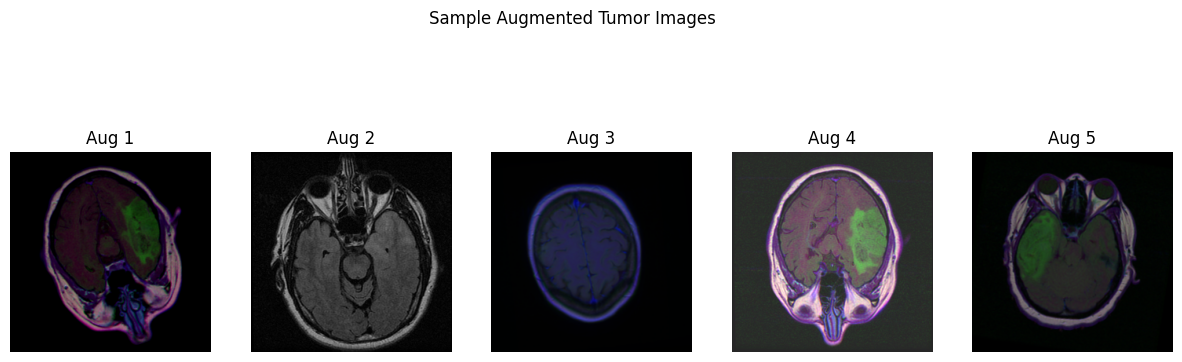

In [29]:
# Visualize some augmented tumor images
n_display = 5  # number of augmented images to show

plt.figure(figsize=(15, 5))

# Sample 5 augmented rows from augmented_df
sampled = augmented_df.sample(n_display)

for i, row in enumerate(sampled.itertuples(), 1):
    img = cv2.imread(row.image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, n_display, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Aug {i}")

plt.suptitle("Sample Augmented Tumor Images")
plt.show()


In [30]:
# %% 
# Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Compute split sizes
n_total = len(df_balanced)
n_train = int(0.8 * n_total)
n_val   = int(0.1 * n_total)
n_test  = n_total - n_train - n_val  # remaining

# Split
train_df = df_balanced.iloc[:n_train]
val_df   = df_balanced.iloc[n_train:n_train+n_val]
test_df  = df_balanced.iloc[n_train+n_val:]

print("Dataset splits:")
print(f"  Training   : {len(train_df)} slices")
print(f"  Validation : {len(val_df)} slices")
print(f"  Test       : {len(test_df)} slices")

# Optional: get separate lists of paths if needed
train_images = train_df['image_path'].tolist()
train_masks  = train_df['mask_path'].tolist()

val_images = val_df['image_path'].tolist()
val_masks  = val_df['mask_path'].tolist()

test_images = test_df['image_path'].tolist()
test_masks  = test_df['mask_path'].tolist()


Dataset splits:
  Training   : 8179 slices
  Validation : 1022 slices
  Test       : 1023 slices


In [31]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import albumentations as A
import numpy as np
from tqdm import tqdm

# --------------------
# Dataset class
# --------------------
class LGGDatasetBalanced(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = row["image_path"]
        mask_path = row["mask_path"]

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            raise ValueError(f"Could not read image: {img_path}")

        if mask is None:
            raise ValueError(f"Could not read mask: {mask_path}")

        img = img / 255.0
        mask = (mask > 0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        img = torch.tensor(img).unsqueeze(0).float()
        mask = torch.tensor(mask).unsqueeze(0).float()

        return img, mask


# --------------------
# Transforms
# --------------------
train_transform = A.Compose([
    A.Resize(128,128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
])

val_transform = A.Compose([A.Resize(128,128)])
test_transform = A.Compose([A.Resize(128,128)])


# --------------------
# Datasets & Loaders
# --------------------
train_dataset = LGGDatasetBalanced(train_df, transform=train_transform)
val_dataset   = LGGDatasetBalanced(val_df,   transform=val_transform)
test_dataset  = LGGDatasetBalanced(test_df,  transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)



In [32]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import albumentations as A
import numpy as np
from tqdm import tqdm

# --------------------
# Dataset class
# --------------------
class LGGDatasetBalanced(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = row["image_path"]
        mask_path = row["mask_path"]

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            raise ValueError(f"Could not read image: {img_path}")

        if mask is None:
            raise ValueError(f"Could not read mask: {mask_path}")

        img = img / 255.0
        mask = (mask > 0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        img = torch.tensor(img).unsqueeze(0).float()
        mask = torch.tensor(mask).unsqueeze(0).float()

        return img, mask


# --------------------
# Transforms
# --------------------
train_transform = A.Compose([
    A.Resize(128,128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
])

val_transform = A.Compose([A.Resize(128,128)])
test_transform = A.Compose([A.Resize(128,128)])


# --------------------
# Datasets & Loaders
# --------------------
train_dataset = LGGDatasetBalanced(train_df, transform=train_transform)
val_dataset   = LGGDatasetBalanced(val_df,   transform=val_transform)
test_dataset  = LGGDatasetBalanced(test_df,  transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)



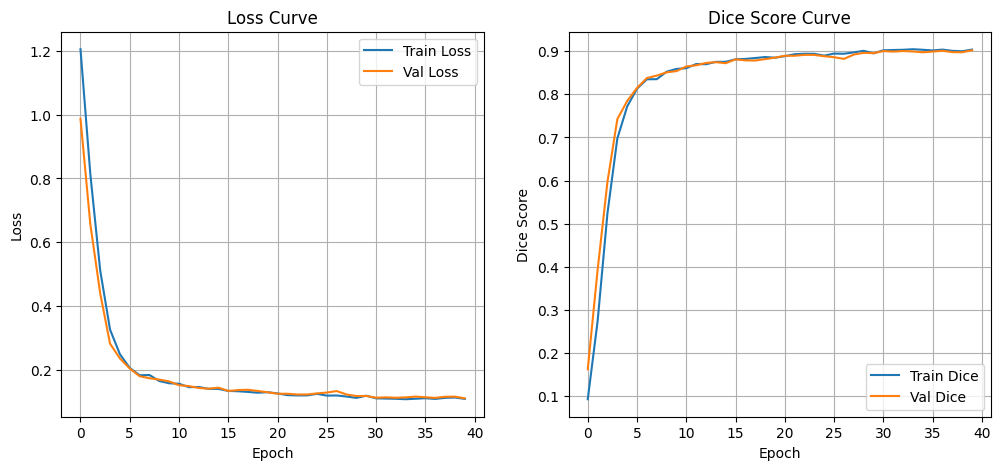

Testing: 100%|██████████| 32/32 [00:01<00:00, 21.79it/s]


 FINAL TEST LOSS: 0.1055


In [33]:


# --------------------
# Model
# --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1
).to(device)

dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=True)
bce_loss  = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# --------------------
# Training
# --------------------
num_epochs = 40
# --------------------
# Training loop with live plotting
# --------------------
from IPython.display import clear_output

train_losses, val_losses = [], []
train_dices, val_dices = [], []

for epoch in range(num_epochs):
    print(f"\n Epoch {epoch+1}/{num_epochs}")

    # ---- TRAIN ----
    model.train()
    train_loss, train_dice_epoch = 0.0, 0.0

    for imgs, masks in tqdm(train_loader, desc="Training", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()

        outputs = model(imgs)
        loss = dice_loss(outputs, masks) + bce_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice_epoch += (1 - dice_loss(outputs, masks).item())

    avg_train_loss = train_loss / len(train_loader)
    avg_train_dice = train_dice_epoch / len(train_loader)
    train_losses.append(avg_train_loss)
    train_dices.append(avg_train_dice)

    # ---- VALIDATION ----
    model.eval()
    val_loss, val_dice_epoch = 0.0, 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc="Validating", leave=False):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)

            loss = dice_loss(outputs, masks) + bce_loss(outputs, masks)
            val_loss += loss.item()
            val_dice_epoch += (1 - dice_loss(outputs, masks).item())

    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice_epoch / len(val_loader)
    val_losses.append(avg_val_loss)
    val_dices.append(avg_val_dice)

    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Train Dice: {avg_train_dice:.4f} | Val Dice: {avg_val_dice:.4f}")

    # ---- Live plotting ----
    clear_output(wait=True)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(train_dices, label="Train Dice")
    plt.plot(val_dices, label="Val Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice Score")
    plt.title("Dice Score Curve")
    plt.legend()
    plt.grid()

    plt.show()

# --------------------
# TEST
# --------------------
model.eval()
test_loss = 0.0

with torch.no_grad():
    for imgs, masks in tqdm(test_loader, desc="Testing"):
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)

        loss = dice_loss(outputs, masks) + bce_loss(outputs, masks)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"\n FINAL TEST LOSS: {avg_test_loss:.4f}")



In [37]:
print(" final train loss:", avg_train_loss, " val loss:", avg_val_loss)
print(" final accuracy:", avg_val_dice)

 final train loss: 0.10810387710807845  val loss: 0.10981261637061834
 final accuracy: 0.9021229650825262


In [34]:
torch.save(model.state_dict(), "models/unet_augmentation.pth")
print("Model saved!")

Model saved!


In [35]:
import torch
import segmentation_models_pytorch as smp
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Recreate model architecture ---
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,  # do not load pretrained weights
    in_channels=1,
    classes=1
)
model.load_state_dict(torch.load("models/unet_weighted_loss.pth", map_location=device))
model = model.to(device)
model.eval()
print("Model loaded and ready!")


# ---  Load saved weights ---
model.load_state_dict(torch.load("models/unet_augmentation.pth", map_location=device))
model = model.to(device)
model.eval()
print("Model loaded and ready!")


Model loaded and ready!
Model loaded and ready!


Visualizing predictions: 100%|██████████| 3/3 [00:00<00:00, 78.70it/s]



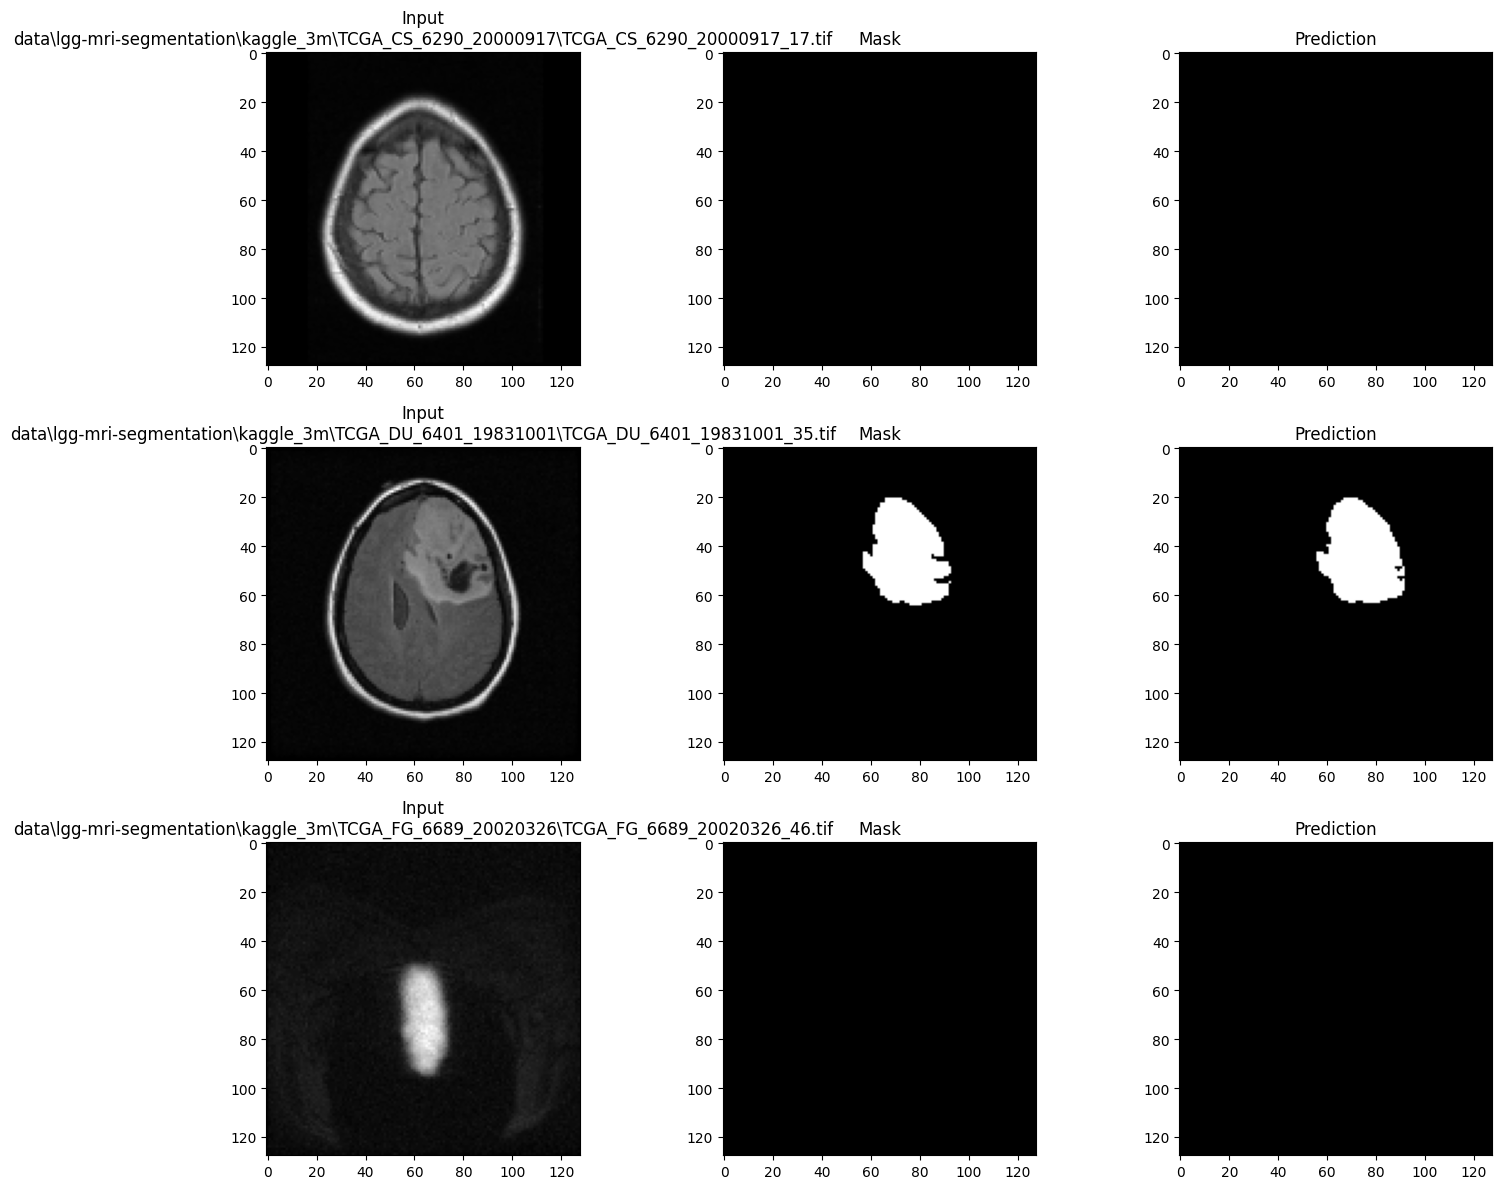

In [36]:



# ---  Pick a random batch from validation loader ---
num_to_plot = 3  # number of images to show
batch_idx = random.randint(0, len(val_loader) - 1)
imgs, masks = list(val_loader)[batch_idx]
imgs, masks = imgs.to(device), masks.to(device)

# --- Get corresponding file paths for this batch ---
batch_start = batch_idx * val_loader.batch_size
batch_paths = [
    val_dataset.df.iloc[batch_start + i].image_path
    for i in range(len(imgs))
]

# --- Forward pass ---
with torch.no_grad():
    preds = model(imgs)
    preds = (preds > 0.5).float()

# --- Visualization ---
plt.figure(figsize=(14, 4 * num_to_plot))

for i in tqdm(range(num_to_plot), desc="Visualizing predictions"):

    file_path = batch_paths[i]

    # Input
    plt.subplot(num_to_plot, 3, i*3 + 1)
    plt.imshow(imgs[i].detach().cpu().squeeze(), cmap='gray')
    plt.title(f"Input\n{file_path}")

    # Mask
    plt.subplot(num_to_plot, 3, i*3 + 2)
    plt.imshow(masks[i].detach().cpu().squeeze(), cmap='gray')
    plt.title("Mask")

    # Prediction
    plt.subplot(num_to_plot, 3, i*3 + 3)
    plt.imshow(preds[i].detach().cpu().squeeze(), cmap='gray')
    plt.title("Prediction")

plt.tight_layout()
plt.show()
